## Leitura dos Dados

In [5]:
pip install numpy==1.23 pandas scikit-learn gensim -q

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ---------------------------------------- 0.0/14.7 MB ? eta -:--:--
   ------------------ --------------------- 6.8/14.7 MB 42.0 MB/s eta 0:00:01
   ---------------------------------------- 14.7/14.7 MB 48.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
Note: you may need to restart the kernel to use updated packages.


  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorboard 2.13.0 requires google-auth-oauthlib<1.1,>=0.5, but you have google-auth-oauthlib 0.4.1 which is incompatible.
tensorboard 2.13.0 requires grpcio>=1.48.2, but you have grpcio 1.42.0 which is incompatible.
tensorboard 2.13.0 requires protobuf>=3.19.6, but you have protobuf 3.17.2 which is incompatible.
tensorboard 2.13.0 requires tensorboard-data-server<0.8.0,>=0.7.0, but you have tensorboard-data-server 0.6.1 which is incompatible.
tensorflow 2.6.0 requires absl-py~=0.10, but you have absl-py 2.1.0 which is incompatible.
tensorflow-intel 2.13.0 requires flatbuffers>=23.1.21, but you have flatbuffers 1.12 which is incompatible.
tensorflow-intel 2.13.0 requires keras<2.14,>=2.13.1, but you have keras 2.6.0 which is incompatible.
tensorflow-intel 2.13.0 requires protob

In [6]:
pip install tensorflow==2.6.0 tensorflow-estimator==2.6.0 keras==2.6.0 tensorflow-gpu==2.6.0 -q

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ---------------------------------------- 0.0/423.3 MB ? eta -:--:--
    --------------------------------------- 7.3/423.3 MB 41.2 MB/s eta 0:00:11
   - -------------------------------------- 17.3/423.3 MB 43.6 MB/s eta 0:00:10
   -- ------------------------------------- 29.1/423.3 MB 47.3 MB/s eta 0:00:09
   --- ------------------------------------ 42.2/423.3 MB 50.7 MB/s eta 0:00:08
   ----- ---------------------------------- 54.3/423.3 MB 51.6 MB/s eta 0:00:08
   ------ --------------------------------- 65.3/423.3 MB 51.4 MB/s eta 0:00:07
   ------- -------------------------------- 76.0/423.3 MB 51.0 MB/s eta 0:00:07
   -------- ------------------------------- 88.1/423.3 MB 52.0 MB/s eta 0:00:07
   --------- ------------------------------ 99.6/423.3 MB 52.1 MB/s eta 0:00:07
   ---------- ---------------------------- 111.1/423.3 MB 52.6 MB/s eta 0:00:06
   ----------- --------------------------- 124.0/423.3 MB

ERROR: Could not install packages due to an OSError: [WinError 5] Acesso negado: 'C:\\Users\\User\\anaconda3\\envs\\gpu_env\\Lib\\site-packages\\h5py\\hdf5.dll'
Consider using the `--user` option or check the permissions.



In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings

warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('../imdb_reviews.csv')
df.head(10)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


# Pré-processamento

Algumas estratégias realizadas no pré-processamento:
- Utilizar regex para a remoção de palavras que começam com caracteres não alfabéticos (números, tags HTML, etc)
- Substituir letras maíuscular por minúsculas
- Substituir caracteres como vírgulas, pontos e hífens

In [3]:
def remove_stop_words(sentence):
    new_sentence = ''
    words = sentence.split()
    new_word_list = [word for word in words if word not in stopwords]
    
    for word in new_word_list:
        new_sentence += ''.join(f" {word}")
    return new_sentence.strip()
    
def apply_regex(sentence):
    new_sentence = ''
    words = sentence.split()
    new_word_list = [word for word in words if re.match(r'^[a-zA-Z]', word)]
    
    for word in new_word_list:
        new_sentence += ''.join(f" {word}")
    
    return new_sentence.strip()

def replace_invalid_char(x):
    x = x.replace(",", "")
    x = x.replace(".", "")
    x = x.replace("-", " ")
    return x
    
    
def preprocess_text(x):
    x = x.lower()
    x = replace_invalid_char(x)
    x = apply_regex(x)
    
    return x

In [4]:
df['review'] = df['review'].apply(preprocess_text)

In [5]:
df.head(10)

,review,sentiment
0,one of the other reviewers has mentioned that ...,positive
1,a wonderful little production filming techniqu...,positive
2,i thought this was a wonderful way to spend ti...,positive
3,basically there's a family where a little boy ...,negative
4,"petter mattei's in the time of money"" is a vis...",positive
5,probably my all time favorite movie a story of...,positive
6,i sure would like to see a resurrection of a u...,positive
7,this show was an amazing fresh innovative idea...,negative
8,encouraged by the positive comments about this...,negative
9,if you like original gut wrenching laughter yo...,positive


# Funções iniciais

In [7]:
def map_sentiments(x):
    if x == 'positive':
        return 1
    return 0

def create_new_dfs(df_train, df_test, text_col, representation, vocab_size=1000):
    
    if representation == 'bow':
        vectorizer = CountVectorizer(max_features=vocab_size)
    elif representation == 'tfidf':
        vectorizer = TfidfVectorizer(norm=None, max_features=vocab_size)
        
    X_train = vectorizer.fit_transform(df_train[text_col].values)
    X_test = vectorizer.transform(df_test[text_col].values)
    
    new_df_train = pd.DataFrame(X_train.toarray(), columns=vectorizer.get_feature_names_out())
    new_df_test = pd.DataFrame(X_test.toarray(), columns=vectorizer.get_feature_names_out())
    
    new_df_train['target_val'] = df_train['sentiment'].values
    new_df_test['target_val'] = df_test['sentiment'].values
    
    return new_df_train, new_df_test


def cross_validation(df, model, representation, k=5):
    idx_list = np.arange(df.shape[0])
    test_available_idx = np.arange(df.shape[0])
    test_size = int((1/k) * len(idx_list))
    acc = 0
    
    print("Accuracy per fold:")
    for i in range(k):
        test_idx = np.random.choice(test_available_idx, test_size, replace=False)
        train_idx = np.setdiff1d(idx_list, test_idx)
        
        df_train = df.iloc[train_idx]
        df_test = df.iloc[test_idx]
        
        train, test = create_new_dfs(df_train, df_test, 'review', representation)
        
        X_train = train.drop('target_val',axis=1)
        y_train = train['target_val'].values
        
        X_test = test.drop('target_val', axis=1)
        y_test = test['target_val'].values
        
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        
        test_available_idx = np.setdiff1d(test_available_idx, test_idx)
        score = accuracy_score(y_test, preds)
        acc += score
        print(f"  Fold number {i+1}: {score:.3f}")
        
    print(f"\nAverage accuracy score is {acc/k:.3f}")

## Bag of Words

- Neste primeiro momento, utilizaremos o Bag of Words como a forma de representação para os nossos dados.
- Para esta forma de representação, cada frase do nosso dataset se torna uma linha com vocab_size + 1 colunas.
- Em cada coluna, temos uma palavra diferente, mais em específico as vocab_size palavras mais comuns.
- O valor em nosso novo dataset para um elemento i,j é o número de aparições da palavra j no review de número i.

In [8]:
df['sentiment'] = df['sentiment'].apply(map_sentiments)

In [9]:
bow_train, bow_val = create_new_dfs(df.loc[:10,:],df.loc[10:20,:], 'review', 'bow')
bow_train

,about,accustomed,acting,action,actors,actual,addiction,adrian,adventureoh,after,...,wrenching,writing,written,years,york,you,young,your,zombie,target_val
0,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,3,0,1,0,1
1,1,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,1
2,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,1,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,0,0,2,0
4,2,0,1,1,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,1
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
6,2,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,2,0,0,0,1
7,0,0,0,0,0,0,0,0,0,1,...,0,1,0,1,0,0,0,0,0,0
8,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,4,1,0,0,1


In [14]:
model_bow = LogisticRegression(max_iter=1000)
cross_validation(df, model_bow, 'bow')

Accuracy per fold:
  Fold number 1: 0.862
  Fold number 2: 0.855
  Fold number 3: 0.857
  Fold number 4: 0.862
  Fold number 5: 0.864

Average accuracy score is 0.860


## TF-IDF (Term Frequency-Inverse Document Frequency)

- Forma de representar a importância das palavras $t$ em documentos $d$
- O TF-IDF de uma palavra é diretamente proporcional à quantidade de aparições da palavra no documento
- É inversamente proporcional ao logaritmo da proporção dos documentos que contém a palavra t em um córpus de tamanho $N$

$$
\text{TF-IDF}(t, d) = \text{TF}(t, d) \times  \log(1 + \frac{N}{{df}_t})
$$

In [16]:
tfidf_train, tfidf_val =  create_new_dfs(df.loc[:10,:],df.loc[10:20,:], 'review', 'tfidf')
tfidf_train

,accustomed,acting,action,actors,actual,addiction,adrian,adventureoh,agenda,agreements,...,would,wrenching,writing,written,years,york,you,young,zombie,target_val
0,2.791759,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.791759,2.791759,...,2.098612,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
1,0.000000,0.000000,0.000000,2.791759,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,2.791759,0.000000,0.000000,2.791759,0.000000,0.000000,1
2,0.000000,0.000000,0.000000,0.000000,0.000000,2.791759,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,2.098612,0.000000,0.000000,2.386294,0.000000,1
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.583519,0
4,0.000000,2.791759,2.791759,0.000000,0.000000,0.000000,2.791759,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,2.791759,0.000000,0.000000,0.000000,1
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,2.098612,0.000000,0.000000,0.000000,0.000000,1
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.791759,0.000000,0.000000,...,10.493061,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,2.791759,0.000000,2.098612,0.000000,0.000000,0.000000,0.000000,0
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,2.791759,0.000000,0.000000,0.000000,0.000000,0.000000,2.386294,0.000000,1


In [89]:
model_tfidf = LogisticRegression(max_iter=1000)
cross_validation(df, model_tfidf, 'tfidf')

Accuracy per fold:
  Fold number 1: 0.867
  Fold number 2: 0.862
  Fold number 3: 0.866
  Fold number 4: 0.864
  Fold number 5: 0.866

Average accuracy score is 0.865


# Word2vec

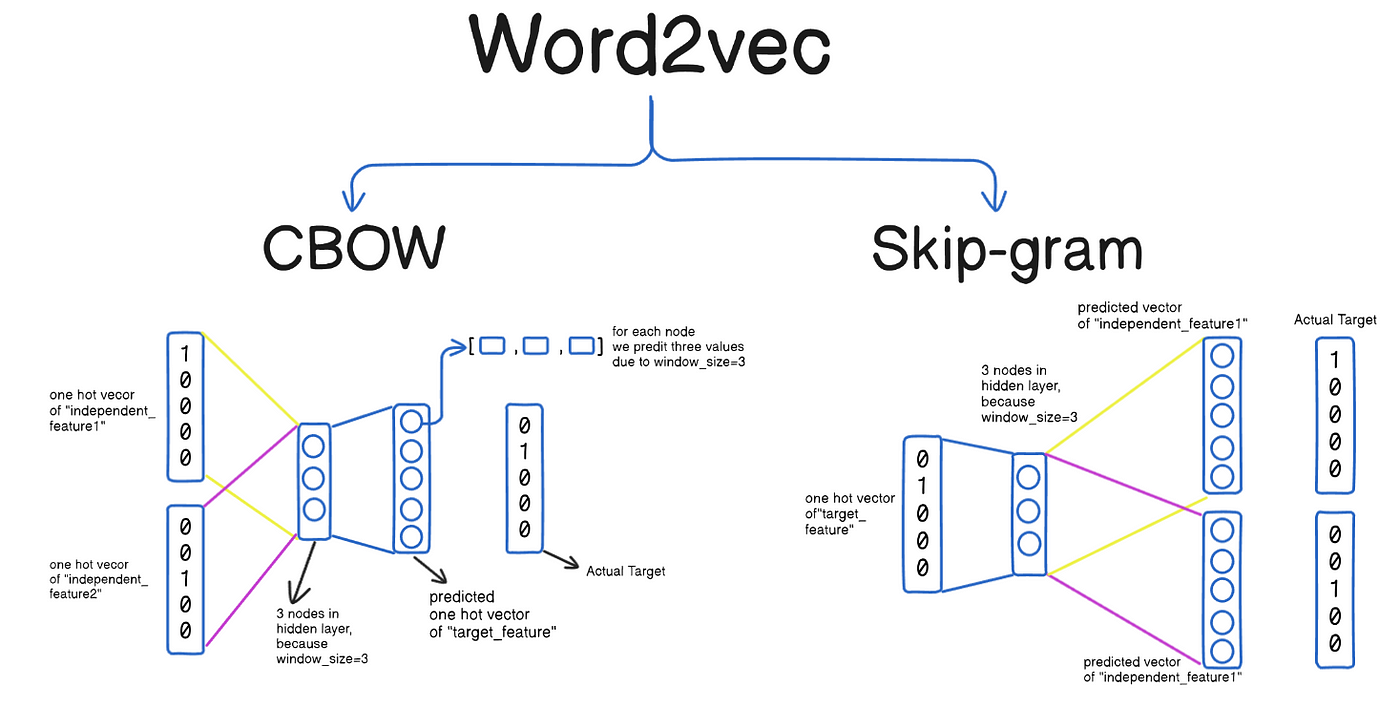

In [10]:
import gensim.downloader as api
# = api.load('word2vec-google-news-300')

In [9]:
from gensim.models import KeyedVectors

w2v = KeyedVectors.load("wv_model")

In [10]:
w2v.most_similar(["movie"], topn=5)

[('film', 0.8676772117614746),
 ('movies', 0.8013108372688293),
 ('films', 0.7363011837005615),
 ('moive', 0.6830361485481262),
 ('Movie', 0.6693680286407471)]

In [14]:
print(f"Length of the embeddings: {len(w2v['movie'])}")
w2v["movie"]

Length of the embeddings: 300


array([ 0.17480469, -0.10986328, -0.20019531,  0.26757812, -0.06396484,
        0.06689453,  0.07958984,  0.08398438,  0.12695312,  0.11621094,
        0.11523438, -0.13867188, -0.08203125, -0.00143433, -0.19824219,
        0.13574219, -0.03955078,  0.06933594, -0.2265625 , -0.20019531,
        0.03076172,  0.16015625, -0.04174805,  0.00427246,  0.09619141,
       -0.03320312,  0.02783203,  0.02124023,  0.13867188, -0.02075195,
       -0.31835938, -0.08837891, -0.23828125,  0.02490234,  0.06787109,
       -0.18066406,  0.27148438,  0.16210938,  0.04614258,  0.20410156,
        0.22949219, -0.03710938,  0.140625  ,  0.12890625, -0.22558594,
        0.03857422, -0.01300049,  0.00582886,  0.23144531,  0.1015625 ,
       -0.10351562, -0.10351562, -0.2578125 ,  0.16503906,  0.03686523,
       -0.32421875,  0.02893066, -0.11914062, -0.19238281,  0.00086594,
        0.06591797,  0.265625  , -0.15917969,  0.26171875, -0.18359375,
        0.13085938, -0.25      , -0.05541992,  0.27929688, -0.06

In [11]:
import tensorflow as tf

print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available: 1


In [12]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow import keras
from tensorflow.keras import layers

# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df["review"])
sequences = tokenizer.texts_to_sequences(df["review"])
word_index = tokenizer.word_index
word_index

{'the': 1,
 'a': 2,
 'and': 3,
 'of': 4,
 'to': 5,
 'is': 6,
 'in': 7,
 'it': 8,
 'this': 9,
 'i': 10,
 'that': 11,
 'was': 12,
 'as': 13,
 'with': 14,
 'movie': 15,
 'for': 16,
 'br': 17,
 'but': 18,
 'film': 19,
 'on': 20,
 'not': 21,
 'you': 22,
 'are': 23,
 'his': 24,
 'have': 25,
 'be': 26,
 'he': 27,
 'one': 28,
 'at': 29,
 'all': 30,
 'by': 31,
 'an': 32,
 'they': 33,
 'from': 34,
 'like': 35,
 'who': 36,
 'so': 37,
 'her': 38,
 'just': 39,
 'or': 40,
 'about': 41,
 'out': 42,
 'has': 43,
 "it's": 44,
 'if': 45,
 'some': 46,
 'there': 47,
 'good': 48,
 'what': 49,
 'more': 50,
 'very': 51,
 'when': 52,
 'up': 53,
 'time': 54,
 'no': 55,
 'would': 56,
 'even': 57,
 'she': 58,
 'my': 59,
 'only': 60,
 'really': 61,
 'story': 62,
 'their': 63,
 'see': 64,
 'had': 65,
 'can': 66,
 'which': 67,
 'me': 68,
 'were': 69,
 'well': 70,
 'than': 71,
 'much': 72,
 'we': 73,
 'been': 74,
 'get': 75,
 'will': 76,
 'bad': 77,
 'other': 78,
 'into': 79,
 'do': 80,
 'great': 81,
 'people': 82,
 

In [13]:
print(f"Length for each sequence is {len(sequences[0])}\n")
print(sequences[0])

Length for each sequence is 302

[28, 4, 1, 78, 2048, 43, 1042, 11, 100, 145, 39, 3551, 394, 466, 26, 3108, 33, 23, 199, 13, 9, 6, 601, 49, 577, 14, 68, 17, 86, 146, 11, 3124, 68, 41, 3551, 12, 93, 5218, 3, 14810, 133, 4, 566, 67, 264, 7, 199, 34, 1, 641, 138, 1775, 68, 9, 6, 21, 2, 118, 16, 1, 7610, 2240, 40, 11012, 9, 118, 2505, 55, 5735, 14, 5509, 5, 1444, 375, 40, 566, 93, 6, 3718, 7, 1, 357, 344, 4, 1, 641, 17, 6, 423, 3551, 13, 11, 6, 1, 11336, 354, 5, 1, 15445, 6866, 2489, 1039, 54152, 8, 2622, 1437, 20, 23613, 531, 32, 4633, 2399, 4, 1, 1178, 120, 30, 1, 6774, 25, 2882, 11849, 3, 386, 54153, 37, 16469, 6, 21, 299, 20, 1, 4761, 7221, 531, 6, 341, 5, 69357, 8143, 41098, 14229, 5009, 7797, 2380, 3, 23614, 46235, 330, 8824, 7161, 12185, 3, 8378, 31989, 23, 110, 224, 241, 17, 56, 130, 1, 274, 1275, 4, 1, 118, 6, 681, 5, 1, 188, 11, 8, 262, 120, 78, 268, 573, 2995, 824, 179, 1271, 4104, 16, 2514, 1192, 824, 1397, 824, 69358, 147, 930, 181, 1, 86, 394, 10, 123, 206, 3124, 68, 13, 37, 

In [14]:
lens = [len(seq) for seq in sequences]
avg_len = int(np.mean(lens))

In [15]:
MAX_LEN = avg_len
X_padded = pad_sequences(sequences, maxlen=MAX_LEN, padding="post")

print(f"Length for each sequence is {len(X_padded[0])}\n")
print(list(X_padded[0]))

Length for each sequence is 225

[6, 3718, 7, 1, 357, 344, 4, 1, 641, 17, 6, 423, 3551, 13, 11, 6, 1, 11336, 354, 5, 1, 15445, 6866, 2489, 1039, 54152, 8, 2622, 1437, 20, 23613, 531, 32, 4633, 2399, 4, 1, 1178, 120, 30, 1, 6774, 25, 2882, 11849, 3, 386, 54153, 37, 16469, 6, 21, 299, 20, 1, 4761, 7221, 531, 6, 341, 5, 69357, 8143, 41098, 14229, 5009, 7797, 2380, 3, 23614, 46235, 330, 8824, 7161, 12185, 3, 8378, 31989, 23, 110, 224, 241, 17, 56, 130, 1, 274, 1275, 4, 1, 118, 6, 681, 5, 1, 188, 11, 8, 262, 120, 78, 268, 573, 2995, 824, 179, 1271, 4104, 16, 2514, 1192, 824, 1397, 824, 69358, 147, 930, 181, 1, 86, 394, 10, 123, 206, 3124, 68, 13, 37, 1600, 8, 12, 2182, 10, 410, 130, 10, 12, 1541, 16, 8, 18, 13, 10, 279, 50, 10, 1372, 2, 1240, 16, 3551, 3, 185, 9744, 5, 1, 299, 1989, 4, 2087, 566, 21, 39, 566, 18, 7341, 4847, 12995, 26, 2888, 42, 16, 2, 24558, 6661, 12995, 497, 20, 613, 3, 75, 241, 14, 8, 70, 7280, 629, 695, 6661, 109, 638, 79, 1178, 19264, 681, 5, 63, 562, 4, 911, 1948, 40,

In [21]:
EMBEDDING_DIM = 300

def create_embedding_matrix(wv, word_index, embedding_dim=300):
    embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
    for word, i in word_index.items():
        if word in wv:
            embedding_matrix[i] = wv[word]
    
    return embedding_matrix

In [ ]:
embedding_matrix_w2v = create_embedding_matrix(w2v, word_index)

In [24]:
k = 5
y_labels = df['sentiment'].values
history_list = []

for i in range(k):
    model = keras.Sequential([
        layers.Embedding(input_dim=len(word_index) + 1, output_dim=EMBEDDING_DIM, 
                         weights=[embedding_matrix], input_length=MAX_LEN, trainable=False),
        layers.LSTM(128, return_sequences=True),
        layers.GlobalMaxPooling1D(),
        layers.Dense(64, activation="relu"),
        layers.Dense(1, activation="sigmoid")
    ])
    
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    history = model.fit(X_padded, y_labels, epochs=3, batch_size=32, validation_split=0.2)
    print('\n')
    history_list.append(history)

Epoch 1/3
1250/1250 [==============================] - 36s 20ms/step - loss: 0.3548 - accuracy: 0.8422 - val_loss: 0.2842 - val_accuracy: 0.8805
Epoch 2/3
1250/1250 [==============================] - 24s 19ms/step - loss: 0.2511 - accuracy: 0.8965 - val_loss: 0.2490 - val_accuracy: 0.8951
Epoch 3/3
1250/1250 [==============================] - 24s 19ms/step - loss: 0.2023 - accuracy: 0.9184 - val_loss: 0.2431 - val_accuracy: 0.9024
Epoch 1/3
1250/1250 [==============================] - 26s 19ms/step - loss: 0.3436 - accuracy: 0.8448 - val_loss: 0.2693 - val_accuracy: 0.8867
Epoch 2/3
1250/1250 [==============================] - 24s 19ms/step - loss: 0.2476 - accuracy: 0.8984 - val_loss: 0.2506 - val_accuracy: 0.8952
Epoch 3/3
1250/1250 [==============================] - 24s 19ms/step - loss: 0.1994 - accuracy: 0.9216 - val_loss: 0.2875 - val_accuracy: 0.8791
Epoch 1/3
1250/1250 [==============================] - 27s 20ms/step - loss: 0.3934 - accuracy: 0.8167 - val_loss: 0.2860 - val_ac

In [17]:
def show_results(history_list):
    val_acc = []
    print("Accuracy per fold:")
    
    for i, history in enumerate(history_list):
        curr_acc = history.history['val_accuracy'][2]
        val_acc.append(curr_acc)
        
        print(f"Fold number {i + 1}: {curr_acc:.3f}")
    
    print(f"\nAverage accuracy score: {np.mean(val_acc):.3f}")

In [38]:
show_results(history_list)

Accuracy per fold:
Fold number 1: 0.902
Fold number 2: 0.879
Fold number 3: 0.897
Fold number 4: 0.899
Fold number 5: 0.898

Average accuracy score: 0.895


# FastText

In [18]:
ft = api.load('fasttext-wiki-news-subwords-300')

In [19]:
ft.most_similar(["movie"], topn=5)

[('film', 0.8769421577453613),
 ('movie-', 0.8271826505661011),
 ('movies', 0.7997195720672607),
 ('film--', 0.7811053991317749),
 ('movie.', 0.7665870785713196)]

In [22]:
embedding_matrix_ft = create_embedding_matrix(ft, word_index)

In [ ]:
k = 5
y_labels = df['sentiment'].values
history_list = []

for i in range(k):
    model = keras.Sequential([
        layers.Embedding(input_dim=len(word_index) + 1, output_dim=EMBEDDING_DIM, 
                         weights=[embedding_matrix_ft], input_length=MAX_LEN, trainable=False),
        layers.LSTM(128, return_sequences=True),
        layers.GlobalMaxPooling1D(),
        layers.Dense(64, activation="relu"),
        layers.Dense(1, activation="sigmoid")
    ])
    
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    history = model.fit(X_padded, y_labels, epochs=3, batch_size=32, validation_split=0.2)
    print('\n')
    history_list.append(history)

Epoch 1/3
1250/1250 [==============================] - 32s 20ms/step - loss: 0.4229 - accuracy: 0.8000 - val_loss: 0.3043 - val_accuracy: 0.8735
Epoch 2/3
1250/1250 [==============================] - 24s 19ms/step - loss: 0.2984 - accuracy: 0.8736 - val_loss: 0.2735 - val_accuracy: 0.8861
Epoch 3/3
1250/1250 [==============================] - 24s 19ms/step - loss: 0.2636 - accuracy: 0.8903 - val_loss: 0.2692 - val_accuracy: 0.8892


Epoch 1/3
1250/1250 [==============================] - 27s 20ms/step - loss: 0.4021 - accuracy: 0.8092 - val_loss: 0.3156 - val_accuracy: 0.8679
Epoch 2/3
1250/1250 [==============================] - 24s 19ms/step - loss: 0.2941 - accuracy: 0.8779 - val_loss: 0.2774 - val_accuracy: 0.8847
Epoch 3/3
1250/1250 [==============================] - 24s 20ms/step - loss: 0.2572 - accuracy: 0.8943 - val_loss: 0.2559 - val_accuracy: 0.8887


Epoch 1/3
1250/1250 [==============================] - 27s 20ms/step - loss: 0.4075 - accuracy: 0.8067 - val_loss: 0.2996 - va

In [ ]:
show_results(history_list)